# Planning

## Big Picture
* **Frame the problem:** Supervised Learning, Univariate Classification Task, Batch Learning (No continuous flow of data, No need to adjust to changing data rapidly)
* **Performance Measure**
* **Check Assumptions**

## Get Data
* **Split Test Data** Use stratified sampling
* **Sample Exploration Set**

## Data Exploration
* Number of features
* Missing values
* Categorial or Numerical
* Correlations
* How do cancelations relate to airport location
* Look at scetterplot to detect outliers (features with outliers should be standardized, non-normal features should be normalized, use log-transformation)
* Feature Engineering

## Data Pre-Processing
* Seperate predictors and labels
* Handle Missing values
* Handle Catigorical Data (ordinal encoding or one-hot encoding)

## Select and Train Model

# Project

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import chi2_contingency

## Import Data

### Import Small/ Medium Datasets

In [3]:
#Specify the path to the data
path_to_data = '/Users/samuelhope/myStuff/StAndrewsYear4/Semester2/ID5059/Project1_Flight_Prediction/Combined_Flights_small.csv'

#Import the data as pandas dataframe
flights_raw = pd.read_csv(path_to_data,usecols=['Airline','Quarter', 'Origin', 'Dest', 'Year', 'Month','DayOfWeek','CRSDepTime','Distance','Disruption'])
#flights_raw = pd.read_csv(path_to_data)

# Clear the maximum number of columns to be displayed, so that all will be visible.
pd.set_option('display.max_columns', None)

display(flights_raw)

,Airline,Origin,Dest,CRSDepTime,Distance,Year,Quarter,Month,DayOfWeek,Disruption
0,SkyWest Airlines Inc.,SLC,LAX,1953,590,2018,3,9,5,0
1,Air Wisconsin Airlines Corp,ORD,ILM,1355,760,2018,2,6,3,1
2,Southwest Airlines Co.,MCO,SJU,1705,1189,2018,1,3,3,0
3,JetBlue Airways,JFK,LAX,1046,2475,2018,1,2,7,0
4,Endeavor Air Inc.,ROC,JFK,1850,264,2018,4,10,5,0
...,...,...,...,...,...,...,...,...,...,...
29186,Capital Cargo International,PHL,SYR,1358,228,2022,2,6,2,0
29187,Southwest Airlines Co.,SMF,LGB,1715,387,2022,3,7,3,0
29188,SkyWest Airlines Inc.,LRD,DFW,1821,396,2022,3,7,3,0
29189,American Airlines Inc.,PVD,CLT,1946,683,2022,3,7,7,1


### Import Large/ Huge Datasets

In [3]:
features = ['Airline','Origin', 'Dest','CRSDepTime','Distance', 'Year','Quarter', 'Month','DayOfWeek','Disruption']
features_index = [1,2,3,4,6,7,8,9,11,44]

def import_large(path, features, features_index):   
    data = pd.read_csv(path)
    data.reset_index(inplace=True)
    data = data.iloc[:,features_index]
    data.columns = features
    return data
    
path_to_data = '/cs/datasets/ID5059/Coursework1/4_huge/'
test_csv_names = ['Combined_Flights_test_2018.csv',
                  'Combined_Flights_test_2019.csv',
                  'Combined_Flights_test_2020.csv',
                  'Combined_Flights_test_2021.csv',
                  'Combined_Flights_test_2022.csv'] 
data = []
for csv_name in test_csv_names:
    full_path = path_to_data + csv_name
    year_data = import_large(full_path,features,features_index)
    data.append(year_data)

flights_raw = pd.concat(data,ignore_index=True)
display(flights_raw)

,Airline,Origin,Dest,CRSDepTime,Distance,Year,Quarter,Month,DayOfWeek,Disruption
0,Alaska Airlines Inc.,AUS,SFO,600,1504,2018,3,9,4,0.0
1,SkyWest Airlines Inc.,LAX,MRY,1110,266,2018,4,10,6,0.0
2,JetBlue Airways,CHS,DCA,1450,444,2018,2,5,7,1.0
3,United Air Lines Inc.,ORD,IAH,2110,925,2018,4,12,7,0.0
4,United Air Lines Inc.,BWI,SFO,1905,2457,2018,3,7,4,0.0
...,...,...,...,...,...,...,...,...,...,...
5838749,Southwest Airlines Co.,PHX,BNA,1555,1449,2022,2,5,6,0.0
5838750,United Air Lines Inc.,ORD,PIT,1805,413,2022,3,7,5,1.0
5838751,Envoy Air,ORD,GRR,2040,137,2022,2,4,3,0.0
5838752,Frontier Airlines Inc.,XNA,DEN,1327,616,2022,2,6,4,1.0


## Data Exploration

In [5]:
flights_raw.replace('NA',pd.NA, inplace=True)

data_summary = pd.concat([flights_raw.count().to_frame('total'),
                          flights_raw.nunique().to_frame(name='nunique'),
                          flights_raw.isna().sum().to_frame(name='isna'),
                          flights_raw.dtypes.to_frame(name='Dtype')],axis=1)

data_summary

,total,nunique,isna,Dtype
Airline,5838754,28,0,object
Origin,5838754,388,0,object
Dest,5838754,387,0,object
CRSDepTime,5838754,1411,0,int64
Distance,5838754,1731,0,int64
Year,5838754,5,0,int64
Quarter,5838754,4,0,int64
Month,5838754,12,0,int64
DayOfWeek,5838754,7,0,int64
Disruption,5838634,2,120,float64


In [6]:
mask = flights_raw.isnull().any(axis=1)
flights_raw[mask]

,Airline,Origin,Dest,CRSDepTime,Distance,Year,Quarter,Month,DayOfWeek,Disruption
9053,Endeavor Air Inc.,MSP,PIA,2035,342,2018,1,1,1,NaN
14671,Endeavor Air Inc.,ATL,FSM,2143,579,2018,1,1,7,NaN
24409,Endeavor Air Inc.,TYS,DTW,605,443,2018,2,4,2,NaN
31929,Endeavor Air Inc.,MCI,LGA,640,1107,2018,1,1,2,NaN
35541,Endeavor Air Inc.,ATL,SAV,1628,214,2018,1,1,4,NaN
...,...,...,...,...,...,...,...,...,...,...
1048726,Endeavor Air Inc.,SGF,ATL,1811,563,2018,2,4,3,NaN
1060868,Endeavor Air Inc.,CVG,CLT,1630,335,2018,1,1,1,NaN
1072204,Endeavor Air Inc.,DCA,JFK,600,213,2018,2,4,5,NaN
1108859,Endeavor Air Inc.,LGA,SYR,1210,198,2018,2,4,1,NaN


In [7]:
#Drop missing values
flights_raw = flights_raw.dropna()

#Convert Object Columns to integer columns (if not already)
flights_raw['Month'] = flights_raw['Month'].astype(int)
flights_raw['DayOfWeek'] = flights_raw['DayOfWeek'].astype(int)
flights_raw['CRSDepTime'] = flights_raw['CRSDepTime'].astype(int)
flights_raw['Distance'] = flights_raw['Distance'].astype(int)
flights_raw['Disruption'] = flights_raw['Disruption'].astype(int)

We can see some missing values for the feature `'Disruption'`. Since this is the variable we are trying to predict, imputation does not make sense and we just drop the missing columns.

We will first investigate how many flights are disrupted for different airlines.

,Variable,Value
0,Chi-square,2.525027e+02
1,p-value,1.765739e-38
2,Degrees of Freedom,2.700000e+01


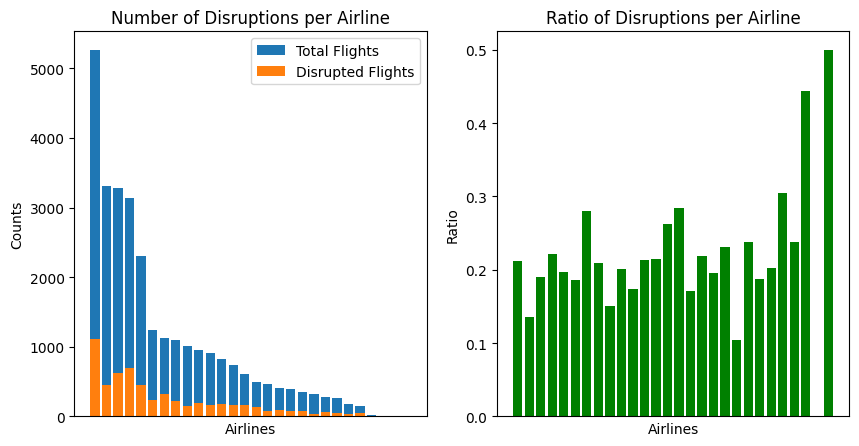

In [48]:
#Chi-square test
crosstab = pd.crosstab(flights_raw['Airline'],flights_raw['Disruption'])
chi2, p, dof, expected = chi2_contingency(crosstab)
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'Value': [chi2, p, dof]
})



airline_data = pd.merge(flights_raw['Airline'].value_counts(),flights_raw.groupby('Airline')['Disruption'].sum(),left_index=True, right_index=True)
airline_data.columns = ["Flights","Disruptions"]
airline_data['Ratio'] = airline_data['Disruptions']/airline_data['Flights']

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(airline_data.index, airline_data['Flights'],label='Total Flights')
ax1.bar(airline_data.index, airline_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions per Airline')
ax1.set_xlabel('Airlines')
ax1.set_ylabel('Counts')
ax1.legend()


ax2.bar(airline_data.index, airline_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions per Airline')
ax2.set_xlabel('Airlines')
ax2.set_ylabel('Ratio')

ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
display(chi2_results)

,Variable,Value
0,Chi-square,1.723239e+02
1,p-value,9.157682e-32
2,Degrees of Freedom,1.000000e+01


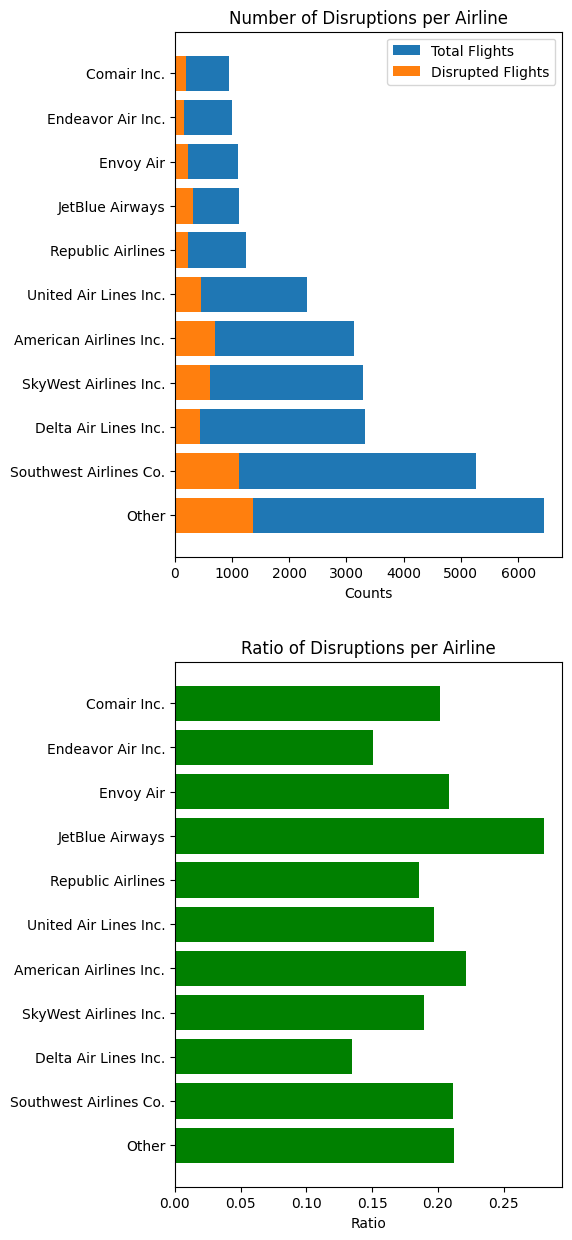

In [49]:
#flights_raw.loc[flights_raw['Airline'].isin(airline_data['Flights'].head(15).index) == False, 'Airline'] = 'Other'
flights_raw['Airline'] = np.where(flights_raw['Airline'].isin(airline_data['Flights'].head(10).index), flights_raw['Airline'], 'Other')
#Chi-square test
crosstab = pd.crosstab(flights_raw['Airline'],flights_raw['Disruption'])
chi2, p, dof, expexcted = chi2_contingency(crosstab)
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'Value': [chi2, p, dof]
})



airline_data = pd.merge(flights_raw['Airline'].value_counts(),flights_raw.groupby('Airline')['Disruption'].sum(),left_index=True, right_index=True)
airline_data.columns = ["Flights","Disruptions"]
airline_data['Ratio'] = airline_data['Disruptions']/airline_data['Flights']

fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(5,15))
ax1.barh(airline_data.index, airline_data['Flights'],label='Total Flights')
ax1.barh(airline_data.index, airline_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions per Airline')
ax1.set_xlabel('Counts')
ax1.legend()


ax2.barh(airline_data.index, airline_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions per Airline')
ax2.set_xlabel('Ratio')
display(chi2_results)

Clearly there are some airlines that have a higher ratio of disrupted flights than others.
We can see that the airlines that have fewer flights recorded in the dataset have more variation in their ratio. Still there are some airlines that have a higher ratio of disrupted flights than others with similar number of flights. There is a reasonable number of unique airlines in the dataset so we can simply use one-hot encoding to encode the airlines. 

Next we will see how disruptions are distributed across the years.

,Variable,Value
0,Chi-square,1.585720e+02
1,p-value,2.959158e-33
2,Degrees of Freedom,4.000000e+00


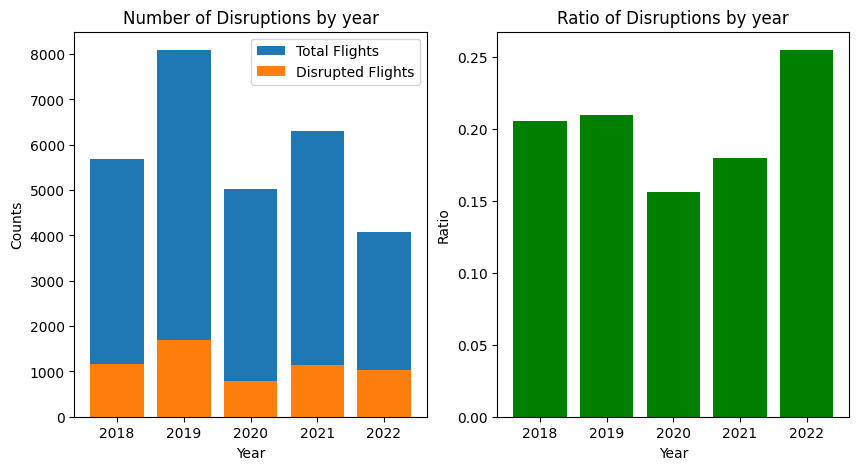

In [10]:
#Chi-square test
crosstab = pd.crosstab(flights_raw['Year'],flights_raw['Disruption'])
chi2, p, dof, expected = chi2_contingency(crosstab)
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'Value': [chi2, p, dof]
})

year_data = pd.merge(flights_raw['Year'].value_counts(),flights_raw.groupby('Year')['Disruption'].sum(),left_index=True, right_index=True)
year_data.columns = ["Flights","Disruptions"]
year_data['Ratio'] = year_data['Disruptions']/year_data['Flights']


fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(year_data.index, year_data['Flights'],label='Total Flights')
ax1.bar(year_data.index, year_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions by year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Counts')
ax1.legend()


ax2.bar(year_data.index, year_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions by year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Ratio')
display(chi2_results)

,Variable,Value
0,Chi-square,4.080976e+01
1,p-value,7.175822e-09
2,Degrees of Freedom,3.000000e+00


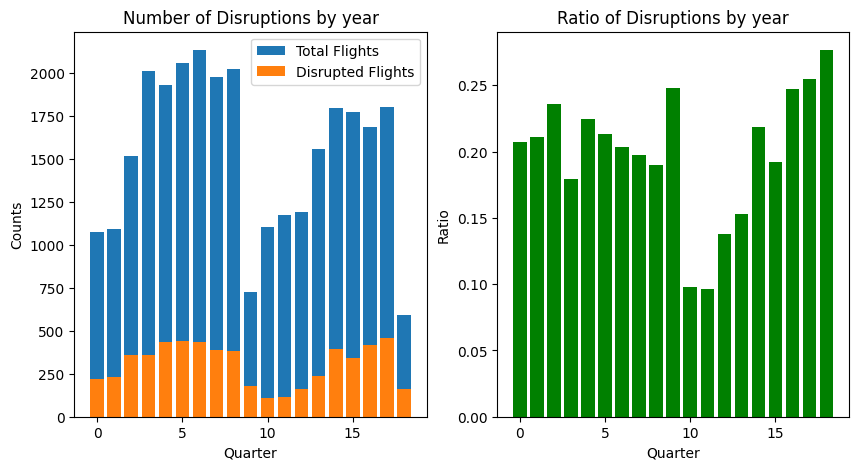

In [11]:
#Chi-square test
crosstab = pd.crosstab(flights_raw['Quarter'],flights_raw['Disruption'])
chi2, p, dof, expected = chi2_contingency(crosstab)
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'Value': [chi2, p, dof]
})

quarter_data = pd.merge(flights_raw.groupby(['Year','Quarter']).size().reset_index(name='Flights'),
         flights_raw.groupby(['Year','Quarter'])['Disruption'].sum().reset_index(name='Disruptions'),
         left_index=True, right_index=True)
quarter_data['Ratio'] = quarter_data['Disruptions']/quarter_data['Flights']


fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(quarter_data.index, quarter_data['Flights'],label='Total Flights')
ax1.bar(quarter_data.index, quarter_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions by year')
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Counts')
ax1.legend()


ax2.bar(quarter_data.index, quarter_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions by year')
ax2.set_xlabel('Quarter')
ax2.set_ylabel('Ratio')
display(chi2_results)

We may want to incooperate the effects of the Covid 19 pandemic. This has lead to a strong reduction in flights in 2020 and 2021. After the pandemic a lot of airports were understaffed which could be the reason for an increased number of disruptions. Since there is only a small number of years in the data, it makes sense to treat it as a categorical feature and use one-hot encoding to let the model associate the years with different rates of disruption.  

It is reasonable to assume that the number of fligths and disuptions follow a seasonal pattern throughout the year so we will proceed by looking at monthly data.

,Variable,Value
0,Chi-square,25966.586879
1,p-value,0.000000
2,Degrees of Freedom,11.000000


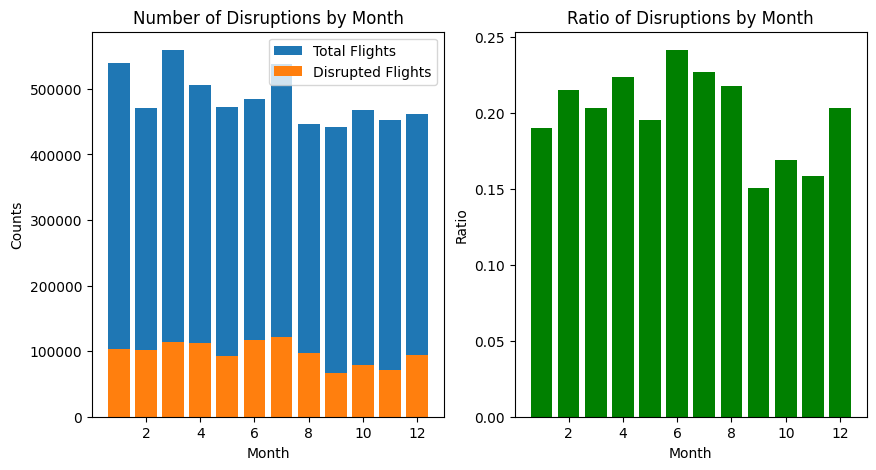

In [15]:
#Chi-square test
crosstab = pd.crosstab(flights_raw['Month'],flights_raw['Disruption'])
chi2, p, dof, expected = chi2_contingency(crosstab)
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'Value': [chi2, p, dof]
})

month_data = pd.merge(flights_raw['Month'].value_counts(),flights_raw.groupby('Month')['Disruption'].sum(),left_index=True, right_index=True)
month_data.columns = ["Flights","Disruptions"]
month_data['Ratio'] = month_data['Disruptions']/month_data['Flights']


fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(month_data.index, month_data['Flights'],label='Total Flights')
ax1.bar(month_data.index, month_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions by Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Counts')
ax1.legend()


ax2.bar(month_data.index, month_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions by Month')
ax2.set_xlabel('Month')
ax2.set_ylabel('Ratio')
display(chi2_results)

Clearly there is a higher ratio of disrupted flights in months April, Juli and August, compared to September, October and November. In this case it makes sense to use cylcical encoding such that the model understanda that months December  and January are just as close together as January and Feburary.

,Variable,Value
0,Chi-square,33.312393
1,p-value,0.000009
2,Degrees of Freedom,6.000000


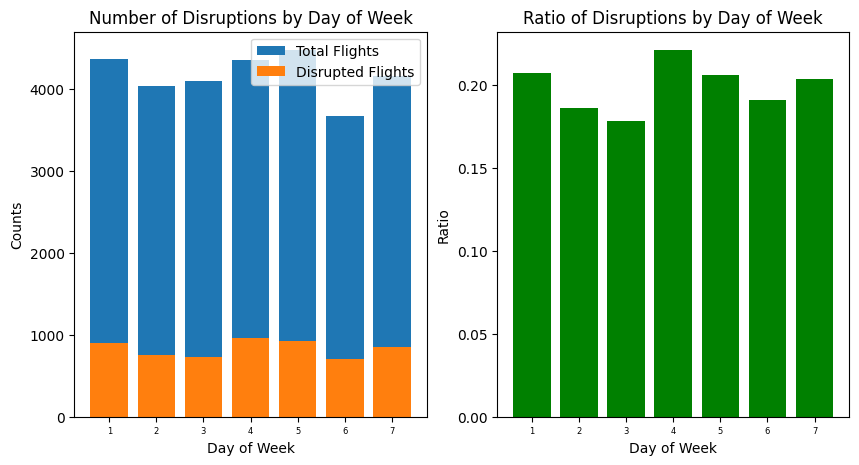

In [12]:
#Chi-square test
crosstab = pd.crosstab(flights_raw['DayOfWeek'],flights_raw['Disruption'])
chi2, p, dof, expected = chi2_contingency(crosstab)
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'Value': [chi2, p, dof]
})

nflights_by_time = flights_raw['DayOfWeek'].value_counts()
ndisruptions_by_time = flights_raw.groupby('DayOfWeek')['Disruption'].sum()
time_data = pd.merge(nflights_by_time,ndisruptions_by_time,left_index=True, right_index=True)
time_data.columns = ["Flights","Disruptions"]
time_data['Ratio'] = time_data['Disruptions']/time_data['Flights']

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(time_data.index, time_data['Flights'],label='Total Flights')
ax1.bar(time_data.index, time_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions by Day of Week')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Counts')
ax1.legend()


ax2.bar(time_data.index, time_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions by Day of Week')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Ratio')

ax1.tick_params(axis='x', which='both', labelsize = 6)
ax2.tick_params(axis='x', which='both', labelsize = 6)
display(chi2_results)

To see how the time of day of departure affects flight disruptions, we group time into 4 hour bins.

,Variable,Value
0,Chi-square,93161.695054
1,p-value,0.000000
2,Degrees of Freedom,23.000000


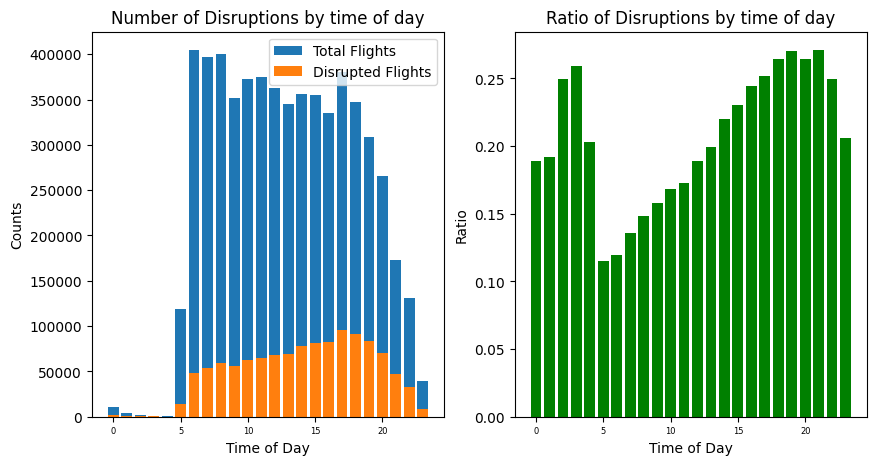

In [18]:
flights_raw['TimeOfDay'] = flights_raw['CRSDepTime'] // 100

#Chi-square test
crosstab = pd.crosstab(flights_raw['TimeOfDay'],flights_raw['Disruption'])
chi2, p, dof, expected = chi2_contingency(crosstab)
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'Value': [chi2, p, dof]
})

nflights_by_time = flights_raw['TimeOfDay'].value_counts()
ndisruptions_by_time = flights_raw.groupby('TimeOfDay')['Disruption'].sum()
time_data = pd.merge(nflights_by_time,ndisruptions_by_time,left_index=True, right_index=True)
time_data.columns = ["Flights","Disruptions"]
time_data['Ratio'] = time_data['Disruptions']/time_data['Flights']

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(time_data.index, time_data['Flights'],label='Total Flights')
ax1.bar(time_data.index, time_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions by time of day')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Counts')
ax1.legend()


ax2.bar(time_data.index, time_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions by time of day')
ax2.set_xlabel('Time of Day')
ax2.set_ylabel('Ratio')

ax1.tick_params(axis='x', which='both', labelsize = 6)
ax2.tick_params(axis='x', which='both', labelsize = 6)
display(chi2_results)

We can see different rates of disruption for different times of the day so this is a variable we want to include. We will therefore feature engineer a new clolumn 'TimeOfDay' for the corresponding hour of departure. We will the use cyclical encoding for the same reason as for the months.

We will now check whether the distance of the flight has an impact on how likely the flight is to be disrupted.

/tmp/ipykernel_233211/401446775.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_data = pd.merge(flights_raw['Distance_Group'].value_counts(),flights_raw.groupby('Distance_Group')['Disruption'].sum(),left_index=True, right_index=True)


,Distance,Disruption
Distance,1.000000,0.012507
Disruption,0.012507,1.000000


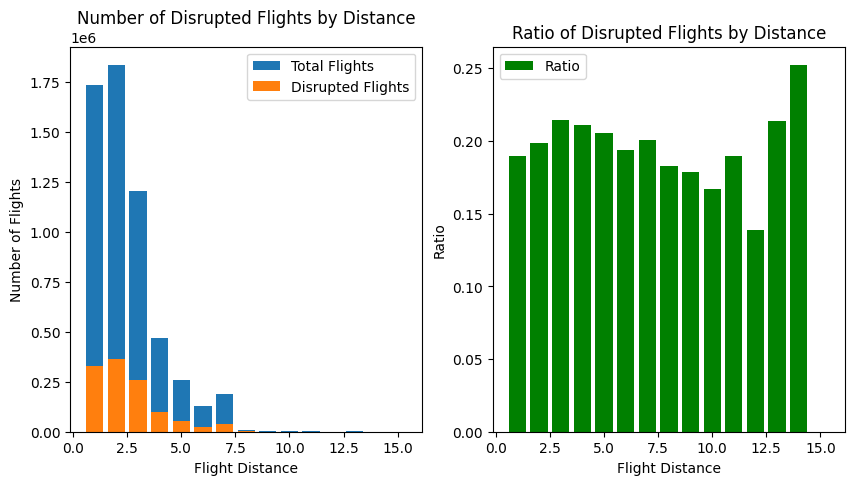

In [47]:
#Split the distances into 10 groups
flights_raw['Distance_Group'] = pd.cut(flights_raw['Distance'], bins=15,labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
distance_data = pd.merge(flights_raw['Distance_Group'].value_counts(),flights_raw.groupby('Distance_Group')['Disruption'].sum(),left_index=True, right_index=True)
distance_data.columns = ["Flights","Disruptions"]


fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(distance_data.index,distance_data['Flights'], label='Total Flights')
ax1.bar(distance_data.index,distance_data['Disruptions'],label='Disrupted Flights')
ax1.set_xlabel('Flight Distance')
ax1.set_ylabel('Number of Flights')
ax1.set_title('Number of Disrupted Flights by Distance')
ax1.legend()

ax2.bar(distance_data.index,distance_data['Disruptions']/distance_data['Flights'], label='Ratio',color='green')
ax2.set_xlabel('Flight Distance')
ax2.set_ylabel('Ratio')
ax2.set_title('Ratio of Disrupted Flights by Distance')
ax2.legend()

flights_raw[['Distance','Disruption']].corr()

The flight distance is the only numerical feature we have. We can see some variability in the histograms and the correlation is reasonably large. We can see a small number of very long flights, so we choose standarisation over normalisation as a scaling technique, to avoid most flights having a value close to $0$.

Next we will investigate how the origin airport affects the chance of a flight being disrupted. There are too many different airports in the dataset so we need to somehow group the data. We first investigate if the busyness of the airport has an impact on the ratio of disrupted flights

5838634

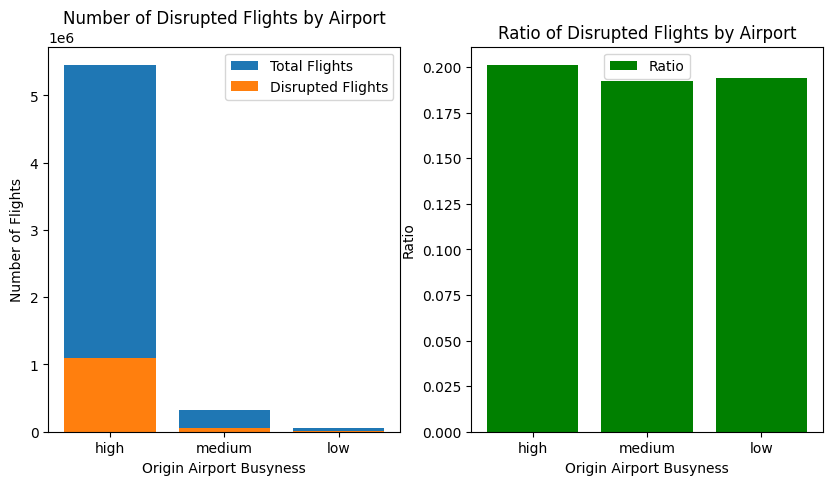

In [48]:
threshholds = list(flights_raw['Origin'].value_counts().quantile([0.33,0.66]))
airline_freqs = flights_raw['Origin'].value_counts()
flights_raw['Busy'] = np.where((airline_freqs[flights_raw['Origin']]<threshholds[0]),'low',
                               np.where((airline_freqs[flights_raw['Origin']]<threshholds[1]),'medium','high'))


busy_data = pd.merge(flights_raw['Busy'].value_counts(),flights_raw.groupby('Busy')['Disruption'].sum(),left_index=True, right_index=True)
busy_data.columns = ["Flights","Disruptions"]

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(busy_data.index,busy_data['Flights'], label='Total Flights')
ax1.bar(busy_data.index,busy_data['Disruptions'],label='Disrupted Flights')
ax1.set_xlabel('Origin Airport Busyness')
ax1.set_ylabel('Number of Flights')
ax1.set_title('Number of Disrupted Flights by Airport')
ax1.legend()

ax2.bar(busy_data.index,busy_data['Disruptions']/busy_data['Flights'], label='Ratio',color='green')
ax2.set_xlabel('Origin Airport Busyness')
ax2.set_ylabel('Ratio')
ax2.set_title('Ratio of Disrupted Flights by Airport')
ax2.legend()

flights_raw['Busy'].value_counts().sum()

The graphs don't suggest that the busyness impacts the relative number of disrupted flights.

Let's see how much the disruption rate varies across different origin airports.

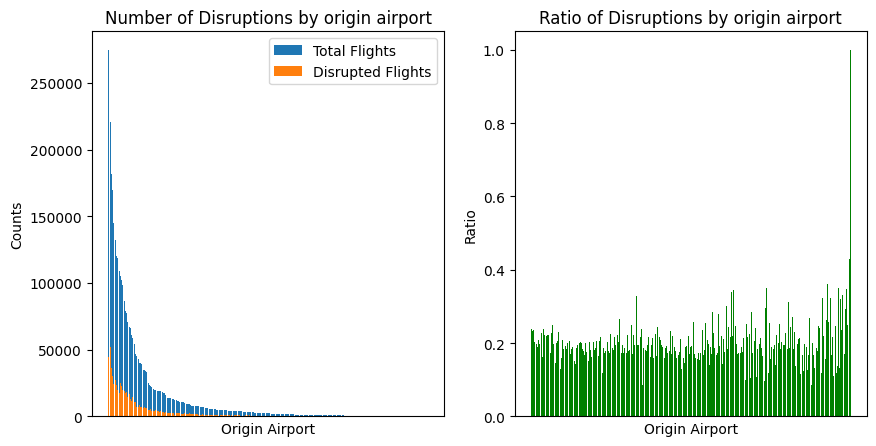

In [49]:
origin_data = pd.merge(flights_raw['Origin'].value_counts(),
                       flights_raw.groupby('Origin')['Disruption'].sum(),
                       left_index=True, right_index=True)

origin_data.columns = ["Flights", "Disruptions"]
origin_data['Ratio'] = origin_data['Disruptions']/origin_data['Flights']


fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(origin_data.index, origin_data['Flights'],label='Total Flights')
ax1.bar(origin_data.index, origin_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions by origin airport')
ax1.set_xlabel('Origin Airport')
ax1.set_ylabel('Counts')
ax1.legend()
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax2.bar(origin_data.index, origin_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions by origin airport')
ax2.set_xlabel('Origin Airport')
ax2.set_ylabel('Ratio')
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

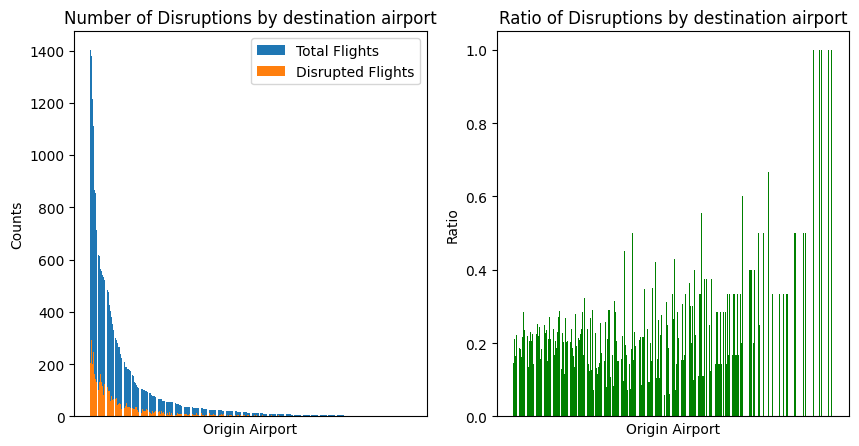

In [10]:
dest_data = pd.merge(flights_raw['Dest'].value_counts(),
                       flights_raw.groupby('Dest')['Disruption'].sum(),
                       left_index=True, right_index=True)

dest_data.columns = ["Flights", "Disruptions"]
dest_data['Ratio'] = dest_data['Disruptions']/dest_data['Flights']


fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(dest_data.index, dest_data['Flights'],label='Total Flights')
ax1.bar(dest_data.index, dest_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions by destination airport')
ax1.set_xlabel('Origin Airport')
ax1.set_ylabel('Counts')
ax1.legend()
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax2.bar(dest_data.index, dest_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions by destination airport')
ax2.set_xlabel('Origin Airport')
ax2.set_ylabel('Ratio')
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

The graphs for the destination and origin airports shows that the number of recorded flights in the dataset varies a lot across airports. The rate of disrupted flights varies a lot, even amongs similarly sized airport, which means that these are good features to include. There are too many different airports to use one-hot encoding and ordinal encoding does not make sense in this context. It makes sense to use target encoding, which encodes the airports with their respective rate of disruption in the training set.

### Summary
We drop any missing rows with missing target variables.
We feature engineer the following features:
* `'TimeOfDay'` (Hour of the day)
* `'Quarter'`(Count)

Standardise the following features:
* `'Distance'`


We one-hotencode the following features as they are non-ordinal:
* `'Airline'`

Use cyclical encoding for the following features:
* `'Quarter'`
* `'Month'`
* `'TimeOfDay'`

Use target encoding for the following features:
* `'Origin'`
* `'Dest'`

## Feature Engineering and Preprocessing

In [49]:
#Drop missing values
flights = flights_raw.dropna()

#Make 'TimeOfDay' column
flights['TimeOfDay'] = flights['CRSDepTime'] // 100

#Modify 'Quarter' column to be unique for each year
flights['Quarter'] = flights_raw['Year'].astype(str) + '_Q' + flights_raw['Quarter'].astype(str)
flights['Quarter'] = pd.Categorical(flights['Quarter'])
flights['Quarter'] = flights['Quarter'].cat.codes + 1

#features = ['Airline', 'Origin', 'Dest', 'Quarter', 'Month', 'DayOfWeek', 'TimeOfDay', 'Disruption']
features = ['Airline', 'Origin', 'Dest', 'Quarter', 'TimeOfDay', 'Disruption']

# Define the features to be one-hot encoded, label encoded and target encoded
#ordinal_encode_features = ['Quarter']
#cyclical_encode_features = ['DayOfWeek', 'Month', 'TimeOfDay']
cyclical_encode_features = ['TimeOfDay']
target_encode_features = ['Origin', 'Dest','Quarter']
one_hot_encode_features = ['Airline']
#standardise_features = ['Distance']

#Split of labels
X = flights[features].drop('Disruption', axis = 1)
y = flights['Disruption']

# Split the data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=17)

class CyclicalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        #X_transformed['DayOfWeek_sin'] = np.sin(2 * np.pi * X_transformed['DayOfWeek'] / 7)
        #X_transformed['DayOfWeek_cos'] = np.cos(2 * np.pi * X_transformed['DayOfWeek'] / 7)
        #X_transformed['Month_sin'] = np.sin(2 * np.pi * X_transformed['Month'] / 12)
        #X_transformed['Month_cos'] = np.cos(2 * np.pi * X_transformed['Month'] / 12)
        X_transformed['Time_sin'] = np.sin(2 * np.pi * X_transformed['TimeOfDay'] / 24)
        X_transformed['Time_cos'] = np.cos(2 * np.pi * X_transformed['TimeOfDay'] / 24)
        #return X_transformed.drop(['DayOfWeek', 'Month'], axis=1)
        return X_transformed.drop(['TimeOfDay'], axis=1)
    def fit_transform(self, X, y=None):
        return self.transform(X)
        
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(handle_unknown='ignore'), one_hot_encode_features),
        ('target_encode', TargetEncoder(), target_encode_features),
        #('quarter_encode', OrdinalEncoder(), ordinal_encode_features),
        ('cyclical', CyclicalTransformer(), cyclical_encode_features),
        #('standardise', StandardScaler(), standardise_features),
    ],
    remainder='passthrough'
)

## Model Fitting and Evaluation

### Model 1: Benchmark Model

In [51]:
class BenchmarkClassifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros(X.shape[0])

Precision: 0
Recall: 0.0
Accuracy: 0.7995549900693806


<Axes: >

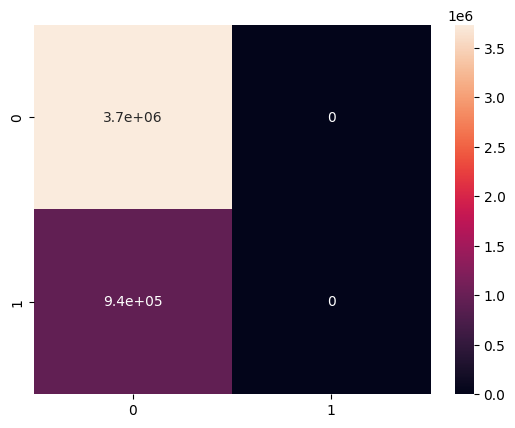

In [53]:
bm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BenchmarkClassifier())
])

# Fit the pipeline on the training data
bm_pipeline.fit(X_train, y_train)


# Evaluate on the test set
y_predictions_bm = bm_pipeline.predict(X_train)
conf_mat = confusion_matrix(y_train, y_predictions_bm)
precision = conf_mat[1,1]/sum(conf_mat[:,1]) if sum(conf_mat[:,1])>0 else 0
recall = conf_mat[1,1]/sum(conf_mat[1,:])
accuracy = (conf_mat[0,0]+conf_mat[1,1])/(sum(conf_mat[0,:])+sum(conf_mat[1,:]))
f1_score = precision*recall/(precision+recall) if (precision+recall)>0 else 0

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
sns.heatmap(conf_mat, annot=True)

### Model 2: Random Forest

In [50]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

#flights_gscv_subsample  = flights.sample(n=10000, random_state=17)
flights_gscv_subsample  = flights
X_subsample = flights_gscv_subsample[features].drop('Disruption', axis = 1)
y_subsample = flights_gscv_subsample['Disruption']


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

# Define the parameter grid for grid search
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_subsample, y_subsample)

best_params_rf, best_score_rf = grid_search.best_params_, grid_search.best_score_
best_params_rf, best_score_rf

({'classifier__max_depth': None,
  'classifier__min_samples_leaf': 4,
  'classifier__min_samples_split': 10,
  'classifier__n_estimators': 200},
 0.8008633105259486)

Precision: 0.20688298918387413
Recall: 0.926056338028169
f1-score: 0.3382092911107539
Accuracy: 0.2949135125877719


<Axes: >

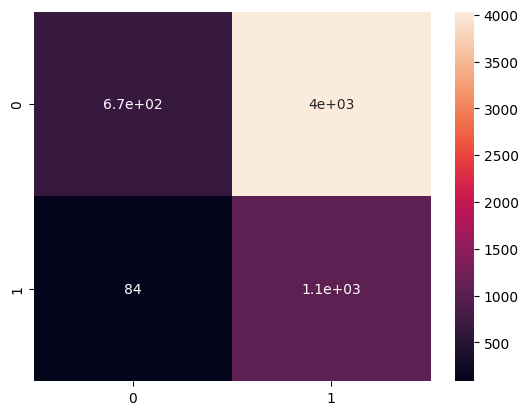

In [57]:
rf_pipeline.set_params(**best_params_rf)

#y_predictions_rf = cross_val_predict(rf_pipeline, X_train, y_train, cv=5)
#conf_mat = confusion_matrix(y_train, y_predictions_rf)

# Evaluate on the validaton set
rf_pipeline.fit(X_train,y_train)
y_scores_rf = rf_pipeline.predict_proba(X_val)
y_pred_rf = np.where(y_scores_rf[:,1] > 0.1, 1,0)
conf_mat = confusion_matrix(y_val, y_pred_rf)


precision = conf_mat[1,1]/sum(conf_mat[:,1]) if sum(conf_mat[:,1])>0 else 'Undefined'
recall = conf_mat[1,1]/sum(conf_mat[1,:])
accuracy = (conf_mat[0,0]+conf_mat[1,1])/(sum(conf_mat[0,:])+sum(conf_mat[1,:]))
f1_score = 2*precision*recall/(precision+recall)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1-score: {f1_score}')
print(f'Accuracy: {accuracy}')
sns.heatmap(conf_mat, annot=True)

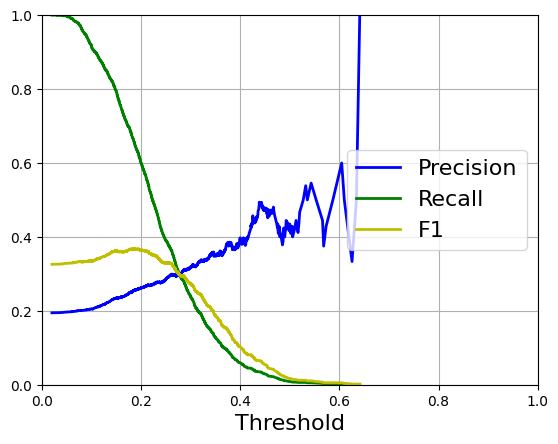

In [55]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    f1_scores = 2 * precisions * recalls / (precisions + recalls)
    plt.plot(
        thresholds,
        precisions[:-1], "b",
        label="Precision",
        linewidth=2)
    plt.plot(
        thresholds,
        recalls[:-1], "g",
        label="Recall",
        linewidth=2)
    plt.plot(
        thresholds,
        f1_scores[:-1], "y",
        label="F1",
        linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([0, 1, 0, 1])
    

precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores_rf[:,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### Model 3: Stochastic Gradient Descent Classifier

In [17]:
sgd_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier())
])

#flights_gscv_subsample  = flights.sample(n=100000, random_state=17)
flights_gscv_subsample  = flights

X_subsample = flights_gscv_subsample[features].drop('Disruption', axis = 1)
y_subsample = flights_gscv_subsample['Disruption']

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'classifier__loss': ['log_loss', 'modified_huber'],
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
    'classifier__max_iter': [1000, 2000, 3000],
    'classifier__tol': [1e-3, 1e-4, 1e-5],
}

grid_search = GridSearchCV(estimator=sgd_pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_subsample, y_subsample)

best_params_sgd, best_score_sgd = grid_search.best_params_, grid_search.best_score_
best_params_sgd, best_score_sgd

({'classifier__alpha': 0.0001,
  'classifier__loss': 'log_loss',
  'classifier__max_iter': 1000,
  'classifier__penalty': 'l1',
  'classifier__tol': 0.0001},
 0.8006919924664816)

Precision: 0.5
Recall: 0.01056338028169014
f1-score: 0.010344827586206896
Accuracy: 0.8054461380373351


<Axes: >

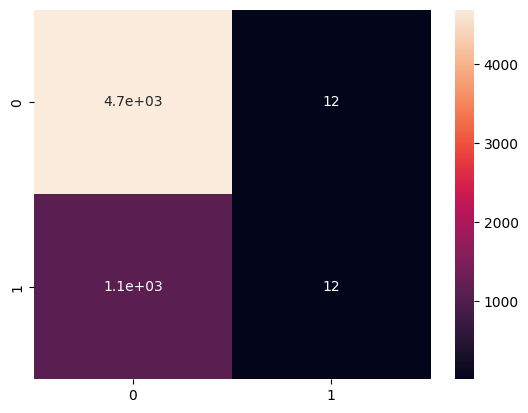

In [30]:
sgd_pipeline.set_params(**best_params_sgd)


# Evaluate on the test set
#y_predictions_sgd = cross_val_predict(sgd_pipeline, X_train, y_train, cv=5)

sgd_pipeline.fit(X_train,y_train)
y_scores_sgd = sgd_pipeline.predict_proba(X_val)
y_pred_sgd = np.where(y_scores_sgd[:,1]>0.5,1,0)
conf_mat = confusion_matrix(y_val, y_pred_sgd)
precision = conf_mat[1,1]/sum(conf_mat[:,1]) if sum(conf_mat[:,1])>0 else 0
recall = conf_mat[1,1]/sum(conf_mat[1,:])
f1_score = 2*precision*recall/(precision+recall)
accuracy = (conf_mat[0,0]+conf_mat[1,1])/(sum(conf_mat[0,:])+sum(conf_mat[1,:]))

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1-score: {f1_score}')
print(f'Accuracy: {accuracy}')
sns.heatmap(conf_mat, annot=True)

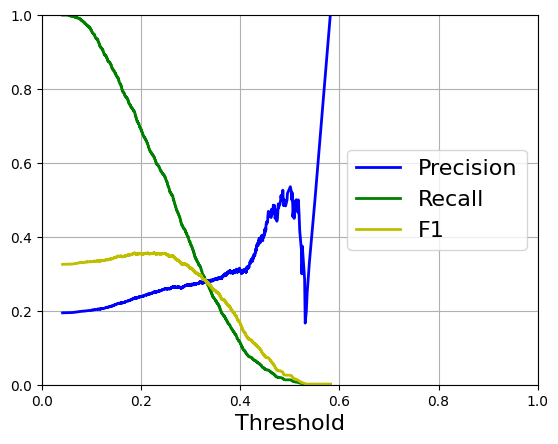

In [23]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores_sgd[:,1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### Model 4: Gradient Boosting Classifier

In [24]:
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__n_estimators': [100, 200, 300],  # Number of boosting stages
    'classifier__learning_rate': [0.05, 0.1, 0.2],  # Learning rate (shrinkage parameter)
    'classifier__max_depth': [3, 4, 5],  # Maximum depth of each tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'classifier__subsample': [0.8, 0.9, 1.0],  # Subsample ratio of the training instances
    'classifier__max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider when looking for the best split
}


grid_search = GridSearchCV(estimator=gb_pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_subsample, y_subsample)

best_params_gb, best_score_gb = grid_search.best_params_, grid_search.best_score_
best_params_gb, best_score_gb

/cs/home/slh27/Documents/ID5059Project1/myenvID5059/lib64/python3.9/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
2187 fits failed out of a total of 8748.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1494 fits failed with the following error:
Traceback (most recent call last):
  File "/cs/home/slh27/Documents/ID5059Project1/myenvID5059/lib64/python3.9/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/cs/home/slh27/Documents/ID5059Project1/myenvID5059/lib64/python3.9/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/cs/home/slh27/Documents/ID5059Project

({'classifier__learning_rate': 0.05,
  'classifier__max_depth': 3,
  'classifier__max_features': 'sqrt',
  'classifier__min_samples_leaf': 4,
  'classifier__min_samples_split': 5,
  'classifier__n_estimators': 100,
  'classifier__subsample': 0.9},
 0.7989995984007962)

Norm: 1.04, NNZs: 36, Bias: -3.529248, T: 12006, Avg. loss: 0.983381
Total training time: 0.00 seconds.
-- Epoch 19
Norm: 1.03, NNZs: 36, Bias: -3.495547, T: 12673, Avg. loss: 1.011146
Total training time: 0.00 seconds.
-- Epoch 20
Norm: 1.03, NNZs: 36, Bias: -3.462266, T: 13340, Avg. loss: 0.982149
Total training time: 0.00 seconds.
-- Epoch 21
Norm: 1.01, NNZs: 36, Bias: -3.435827, T: 14007, Avg. loss: 0.929305
Total training time: 0.00 seconds.
-- Epoch 22
Norm: 1.00, NNZs: 36, Bias: -3.406870, T: 14674, Avg. loss: 0.924668
Total training time: 0.00 seconds.
-- Epoch 23
Norm: 0.99, NNZs: 36, Bias: -3.385087, T: 15341, Avg. loss: 0.888397
Total training time: 0.00 seconds.
-- Epoch 24
Norm: 0.99, NNZs: 36, Bias: -3.355371, T: 16008, Avg. loss: 0.894288
Total training time: 0.00 seconds.
-- Epoch 25
Norm: 0.98, NNZs: 36, Bias: -3.333152, T: 16675, Avg. loss: 0.856261
Total training time: 0.00 seconds.
-- Epoch 26
Norm: 0.97, NNZs: 36, Bias: -3.311089, T: 17342, Avg. loss: 0.852856
Tot

Precision: 0.6
Recall: 0.007922535211267605
Accuracy: 0.805959924644631


<Axes: >

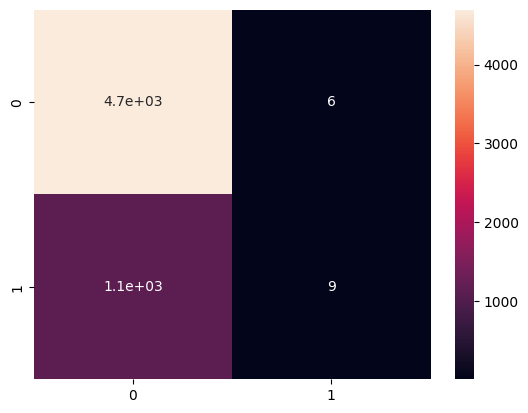

In [78]:
sgd_pipeline.set_params(**best_params_sgd)

#Fit and transform the pipeline on the training data
X_train = gb_pipeline.named_steps['preprocessor'].fit_transform(X_train, y_train)
gb_pipeline.named_steps['classifier'].fit(X_train, y_train)


# Evaluate on the test set
y_predictions_gb = cross_val_predict(gb_pipeline, X_train, y_train, cv=5)
conf_mat = confusion_matrix(y_train, y_predictions)
precision = conf_mat[1,1]/sum(conf_mat[:,1]) if sum(conf_mat[:,1])>0 else 0
recall = conf_mat[1,1]/sum(conf_mat[1,:])
accuracy = (conf_mat[0,0]+conf_mat[1,1])/(sum(conf_mat[0,:])+sum(conf_mat[1,:]))
f1_score = precision*recall/(precision+recall)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1-score: {f1_score}')
print(f'Accuracy: {accuracy}')
sns.heatmap(conf_mat, annot=True)

## Model Testing and Comparison 

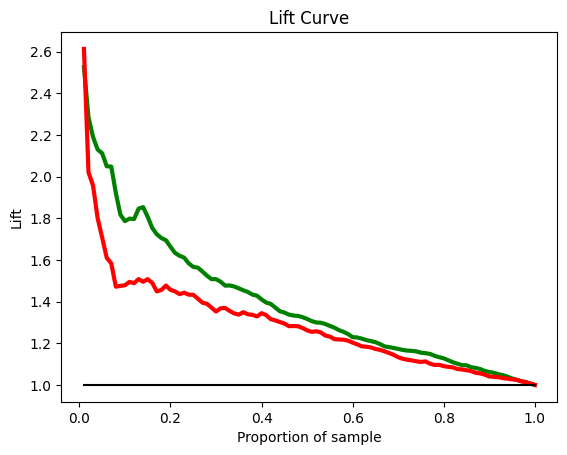

In [36]:
def calc_lift(y_val, y_pred, step=0.01):
    
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
    return x_val, y_v

sample_prop, lift_rf = calc_lift(y_val, y_scores_rf[:,1], step=0.01)
sample_prop, lift_sgd = calc_lift(y_val, y_scores_sgd[:,1], step=0.01)


#Plot the figure
fig, axis = plt.subplots()
fig.figsize = (40,40)
axis.plot(sample_prop, lift_rf, 'g-', linewidth = 3, markersize = 5)
axis.plot(sample_prop, lift_sgd, 'r-', linewidth = 3, markersize = 5)
axis.plot(sample_prop, np.ones(len(sample_prop)), 'k-')
axis.set_xlabel('Proportion of sample')
axis.set_ylabel('Lift')
plt.title('Lift Curve')
plt.show()

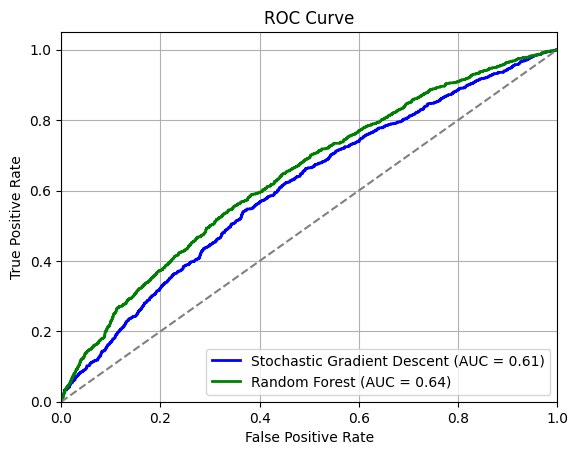

In [40]:
fpr_sgd, tpr_sgd, thresholds = roc_curve(y_val, y_scores_sgd[:,1])
fpr_rf, tpr_rf, thresholds = roc_curve(y_val, y_scores_rf[:,1])

# Compute AUC (Area Under the Curve)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)

# Plot ROC curve
plt.plot(fpr_sgd, tpr_sgd, color='blue', lw=2, label='Stochastic Gradient Descent (AUC = %0.2f)' % roc_auc_sgd)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Plot diagonal line (baseline)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()